Numpy array ...
[ 0.          0.19866933  0.38941834 ...,  0.975078    0.9997186
  0.98450358]
Plot of first 100 points ...


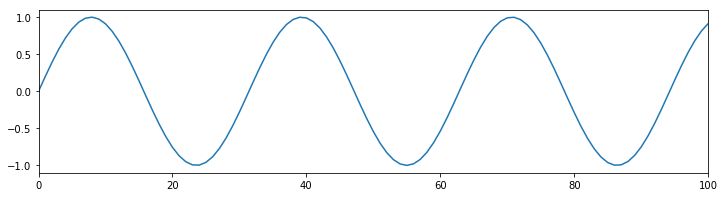

Pandas DataFrame format ...
      sinwave
idx          
0    0.000000
1    0.198669
2    0.389418
3    0.564642
4    0.717356
Saving CSV file ...


In [2]:
from math import sin
import matplotlib.pyplot as plt
import numpy
import pandas

# sin generation parameters 
x0 = 0.0
step = 0.2
nsteps = 10000

data = []
x = x0

for i in range(0,nsteps):
    y = sin(x)
    x = x + step
    data.append(y)
    
# Convert to numpy array
data = numpy.array(data)
print('Numpy array ...')
print(data)

# Plot
print('Plot of first 100 points ...')
plt.rcParams["figure.figsize"] = [12,3]
plt.xlim(0,100)
plt.plot(data)
plt.show()

# Convert to pandas DataFrame format
data = pandas.DataFrame(data)
data.columns = ['sinwave']
data.index.name = 'idx'
print('Pandas DataFrame format ...')
print(data.head())

# save as coma separated value file
print('Saving CSV file ...')
data.to_csv('~/test-data/syntetic-data.csv')

In [3]:
filename = '~/test-data/syntetic-data.csv'

sequence_len = 8
features_len = 2
total_len = sequence_len + features_len

# Read CVS file with data
df = pandas.read_csv(filename,index_col=0)

print('DataFrame after reading CSV file ...')
print(df.head())

# Change the name of the column for numeric
df.columns = [0]

# Create columns with shifted data to create rows of connected data
for i in range(1,total_len):  
    df[i] = df[i-1].shift(-1)
    
# drop all rows with NaN elements 
df = df.dropna()

print('DataFrame after creating sets of data ...')

print(df.head())

DataFrame after reading CSV file ...
      sinwave
idx          
0    0.000000
1    0.198669
2    0.389418
3    0.564642
4    0.717356
DataFrame after creating sets of data ...
            0         1         2         3         4         5         6  \
idx                                                                         
0    0.000000  0.198669  0.389418  0.564642  0.717356  0.841471  0.932039   
1    0.198669  0.389418  0.564642  0.717356  0.841471  0.932039  0.985450   
2    0.389418  0.564642  0.717356  0.841471  0.932039  0.985450  0.999574   
3    0.564642  0.717356  0.841471  0.932039  0.985450  0.999574  0.973848   
4    0.717356  0.841471  0.932039  0.985450  0.999574  0.973848  0.909297   

            7         8         9  
idx                                
0    0.985450  0.999574  0.973848  
1    0.999574  0.973848  0.909297  
2    0.973848  0.909297  0.808496  
3    0.909297  0.808496  0.675463  
4    0.808496  0.675463  0.515501  


In [4]:
import math 

values = df.values
training_len = math.floor(len(values)*0.75)

# Assign training set (train_x) of data series as 75% of the data 
# we have read from the file, the rest will be used a validation 
# (testing) set (test_x) - data is represented by 'traning_len' 
# first columns of the generated vector
train_x = values[:training_len,:-features_len]
test_x  = values[training_len:,:-features_len]

# Assign true values (features) that we will try to predict for training
# and testing parts - this data is represented by last two columns of the 
# original array
train_y = values[:training_len,-features_len:]
test_y  = values[training_len:,-features_len:]

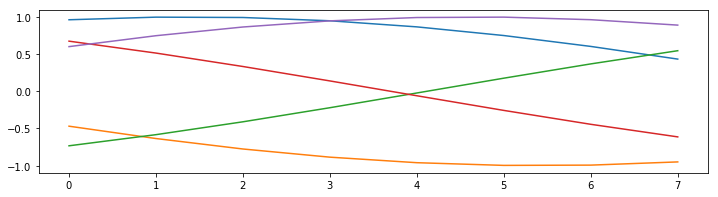

In [5]:
# Plot random sample of training sequences
n_samples = 5

plt.rcParams["figure.figsize"] = [12,3]

dat = df.sample(n_samples).values[:,:-2].T

plt.plot(dat)
plt.show()

In [115]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

def build_model(inp_dim, out_dim, layers):
    model = Sequential()

    # Input shape - 3D tensor with shape (batch_size, timesteps, input_dim), mandatory for the first layer
    model.add(LSTM(units=layers[0],
        input_shape=(inp_dim[0], inp_dim[1]),
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layers[1], return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layers[2], return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=out_dim[0]))
    model.add(Activation("tanh"))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

timesteps = 1
len_per_timestep = 8
b_size = 256 # batch size
n_epochs = 40

# reshape to (n_samples, timesteps, len_per_timestep), len_per_timestep - features per time step
train_x = train_x.reshape((train_x.shape[0], timesteps, len_per_timestep))
test_x = test_x.reshape((test_x.shape[0], timesteps, len_per_timestep))

print(train_x.shape)

model = build_model([timesteps, len_per_timestep], [2], [100,50,50])

history = model.fit(
     train_x,    
     train_y,
     batch_size=b_size,
     validation_data=(test_x, test_y), 
     shuffle=True,
     epochs=n_epochs, 
     verbose=1)

(7493, 1, 8)
Train on 7493 samples, validate on 2498 samples
Epoch 1/40
7493/7493 [==============================] - 4s - loss: 0.3672 - val_loss: 0.1631
Epoch 2/40
7493/7493 [==============================] - 1s - loss: 0.0694 - val_loss: 0.0137
Epoch 3/40
7493/7493 [==============================] - 1s - loss: 0.0151 - val_loss: 0.0095
Epoch 4/40
7493/7493 [==============================] - 1s - loss: 0.0112 - val_loss: 0.0057ss: 0.01
Epoch 5/40
7493/7493 [==============================] - 1s - loss: 0.0080 - val_loss: 0.0033
Epoch 6/40
7493/7493 [==============================] - 1s - loss: 0.0062 - val_loss: 0.0019
Epoch 7/40
7493/7493 [==============================] - 1s - loss: 0.0051 - val_loss: 0.0018
Epoch 8/40
7493/7493 [==============================] - 1s - loss: 0.0045 - val_loss: 0.0019
Epoch 9/40
7493/7493 [==============================] - 1s - loss: 0.0043 - val_loss: 0.0018
Epoch 10/40
7493/7493 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0015


In [116]:
predicted = model.predict(test_x, batch_size=b_size)

In [117]:
def predict_long_range(model, n_points, start_vec, timesteps, len_per_step, labels):
    
    n_vectors = int(n_points/2)
    
    results = []
        
    vec_len = len(start_vec)
    new = start_vec
    
    # Add startring vector to the results
    #for i in range(len(new)):
    #    results.append(new[i])
    
    # run the prediction for 
    for i in range(n_vectors):
        tmp = new.reshape(1,timesteps,len_per_step)
         
        res = model.predict(tmp)
        
        for j in range(2):
            results.append(res[0][j])
        
        tmp = tmp.reshape(vec_len)
        new = (numpy.concatenate((tmp,res[0])))[2:]
           
    return(results)


In [118]:
# use first first vector or the test_x as a start
# for timestep != 1 it should be (test_x[0].T)[0]
# start = (test_x[0].T)[0]
start = (test_x[0])[0]
print(start)
long_range = predict_long_range(model, 100, start, timesteps, len_per_timestep, 2)

[-0.06026769 -0.25737455 -0.4442207  -0.61335717 -0.75804102 -0.87250418
 -0.95218334 -0.99390196]


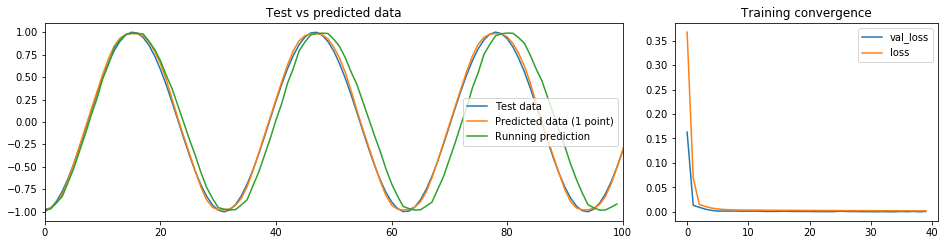

In [119]:
test_data = test_y[:,:-1]
predicted_data = predicted[:,:-1]

plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))

ax1.set_xlim(0,100)
ax1.plot(test_data,label='Test data')
ax1.plot(predicted_data,label='Predicted data (1 point)')
ax1.plot(long_range, label='Running prediction')
ax1.set_title('Test vs predicted data')
ax1.legend()

ax2.plot(history.history['val_loss'],label='val_loss')
ax2.plot(history.history['loss'],label='loss')
ax2.set_title('Training convergence')

plt.legend()
plt.show()

In [136]:
import keras

# To record history we will create a Keras callback class
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
        

def build_model_stateful(batch_size, inp_dim, out_dim, layers):
    model = Sequential()

    # Input shape - 3D tensor with shape (batch_size, timesteps, input_dim), mandatory for the first layer
    model.add(LSTM(units=layers[0], batch_size=batch_size, 
                   input_shape=(inp_dim[0], inp_dim[1]), return_sequences=True,stateful=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layers[1], return_sequences=True, stateful=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=layers[2], return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=out_dim[0]))
    model.add(Activation("tanh"))

    model.compile(loss="mse", optimizer="rmsprop")
    return model

# Traing the stateful model

timesteps = 8
len_per_timestep = 1
b_size = 1 
n_epochs = 10

model = build_model_stateful(b_size, [timesteps, len_per_timestep], [2], [100,50,50])
history = LossHistory()

for i in range(0,3):
    model.fit(train_x, train_y, batch_size=b_size,
         validation_data=(test_x, test_y), shuffle=False, epochs=1, callbacks=[history])
    model.reset_states()

Train on 7493 samples, validate on 2498 samples
Epoch 1/1
7493/7493 [==============================] - 384s - loss: 0.0333 - val_loss: 0.0051
Train on 7493 samples, validate on 2498 samples
Epoch 1/1
7493/7493 [==============================] - 383s - loss: 0.0035 - val_loss: 0.0012
Train on 7493 samples, validate on 2498 samples
Epoch 1/1
7493/7493 [==============================] - 402s - loss: 0.0024 - val_loss: 0.0065


In [137]:
predicted = model.predict(test_x, batch_size=b_size)

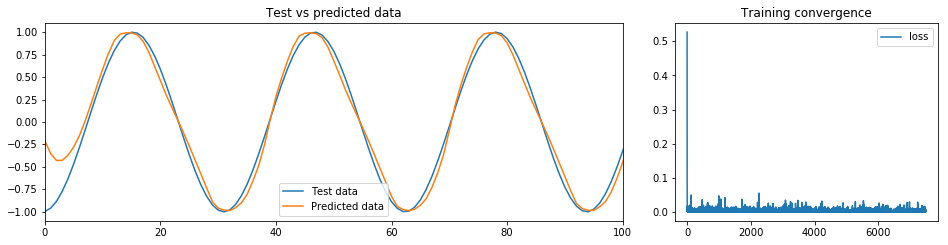

In [138]:
test_data = test_y[:,:-1]
predicted_data = predicted[:,:-1]

plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))

ax1.set_xlim(0,100)
ax1.plot(test_data,label='Test data')
ax1.plot(predicted_data,label='Predicted data')
ax1.set_title('Test vs predicted data')
ax1.legend()

#ax2.plot(history.history['val_loss'],label='val_loss')
ax2.plot(history.losses,label='loss')
ax2.set_title('Training convergence')

plt.legend()
plt.show()